In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/netflix-prize-data/qualifying.txt
/kaggle/input/netflix-prize-data/probe.txt
/kaggle/input/netflix-prize-data/movie_titles.csv
/kaggle/input/netflix-prize-data/combined_data_3.txt
/kaggle/input/netflix-prize-data/combined_data_2.txt
/kaggle/input/netflix-prize-data/README
/kaggle/input/netflix-prize-data/combined_data_1.txt
/kaggle/input/netflix-prize-data/combined_data_4.txt


# This project aims to build a movie recommendation mechanism within Netflix.

   * Learn from data and recommend best TV shows to users, based on self & others behaviour



In [2]:
# importing required liberaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')
import math
import re
from scipy.sparse import csr_matrix
from surprise import Dataset,Reader,SVD
from surprise.model_selection import cross_validate

# Reading the Dataset

In [3]:
df1 = pd.read_csv('/kaggle/input/netflix-prize-data/combined_data_1.txt',header=None,names=['Cust_Id','Rating'],usecols=[0,1])
df1.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 2 columns):
Cust_Id    object
Rating     float64
dtypes: float64(1), object(1)
memory usage: 367.1+ MB


In [ ]:
df2 = pd.read_csv('/kaggle/input/netflix-prize-data/combined_data_2.txt',header=None,names=['Cust_Id','Rating'],usecols=[0,1])
df2.head()

In [ ]:
df2.info()

In [ ]:
df3 = pd.read_csv('/kaggle/input/netflix-prize-data/combined_data_3.txt',header=None,names=['Cust_Id','Rating'],usecols=[0,1])
df3.head()

In [ ]:
df3.info()

In [ ]:
df4 = pd.read_csv('/kaggle/input/netflix-prize-data/combined_data_4.txt',header=None,names=['Cust_Id','Rating'],usecols=[0,1])
df4.head()

In [ ]:
df4.info()

In [ ]:
dft=pd.concat([df1,df2,df3,df4])

In [ ]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(dft.shape)

In [ ]:
df1.shape[0]+df2.shape[0]+df3.shape[0]+df4.shape[0]

In [5]:
df=df1

In [6]:
df.isnull().sum()

Cust_Id       0
Rating     4499
dtype: int64

# Data Visualizing

In [7]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# Getting Movie counts
movie_count=df.isnull().sum()[1]

# Getting customer counts
cust_count = df['Cust_Id'].nunique()-movie_count
# Get rating count
rating_count = df['Cust_Id'].count()-movie_count

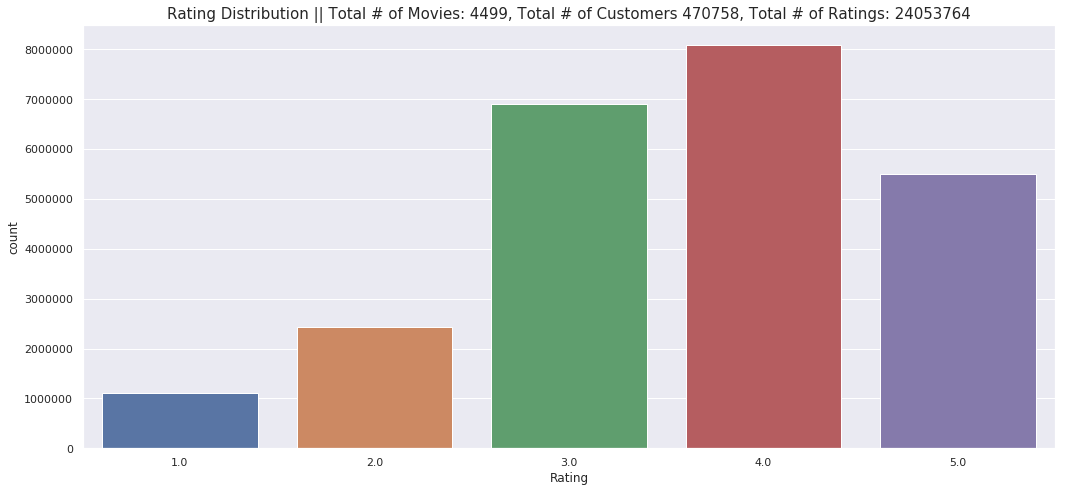

In [8]:
plt.figure(figsize=(15,7))
sns.countplot('Rating',data=df)
plt.title('Rating Distribution || Total # of Movies: {}, Total # of Customers {}, Total # of Ratings: {}'.format(movie_count,cust_count,rating_count),fontsize=15)
plt.tight_layout()
plt.show()

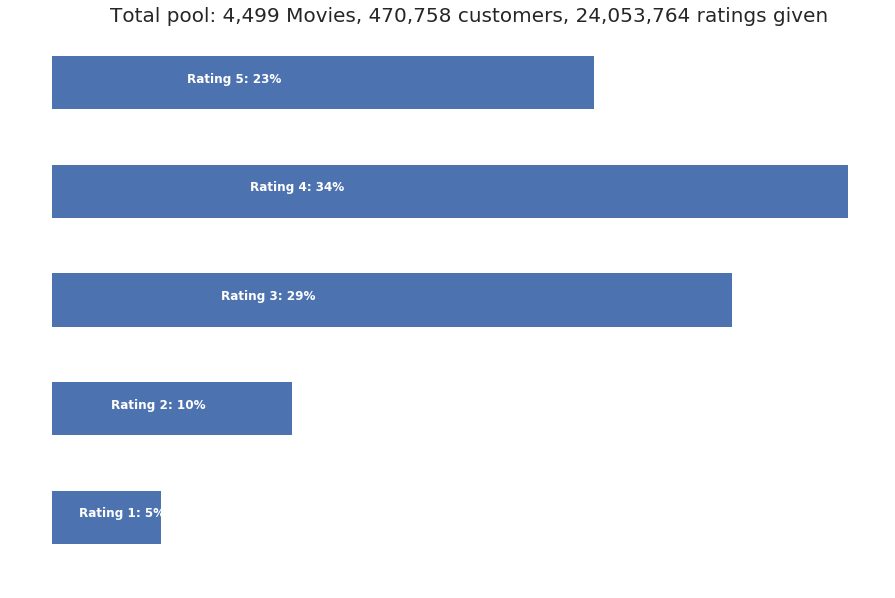

In [9]:
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

* We can see that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. We can keep this in mind - low rating movies mean they are generally really bad


# Data Cleaning

### Data is very large Kernel getting out of memory when using whole data so I am going to use only first part of data

In [10]:
df.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [11]:
df.isnull().sum()

Cust_Id       0
Rating     4499
dtype: int64

In [12]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [13]:
# remove those Movie ID rows
df = df[df['Rating'].notnull()]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)

In [14]:
df.iloc[::5000000, :]

,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
5000996,501954,2.0,996
10001962,404654,5.0,1962
15002876,886608,2.0,2876
20003825,1193835,2.0,3825


In [15]:
df.shape

(24053764, 3)

In [16]:
df.isnull().sum()

Cust_Id     0
Rating      0
Movie_Id    0
dtype: int64

In [17]:
df.describe()

,Cust_Id,Rating,Movie_Id
count,2.405376e+07,2.405376e+07,2.405376e+07
mean,1.322285e+06,3.599634e+00,2.308324e+03
std,7.645779e+05,1.086118e+00,1.303909e+03
min,6.000000e+00,1.000000e+00,1.000000e+00
25%,6.609270e+05,3.000000e+00,1.180000e+03
50%,1.318602e+06,4.000000e+00,2.342000e+03
75%,1.984358e+06,4.000000e+00,3.433000e+03
max,2.649429e+06,5.000000e+00,4.499000e+03


* Removing movie with too less reviews (they are relatively not popular)
* Removing customer who give too less reviews (they are relatively less active)
* This should help to improve the efficiency significantly and als improve the statistical signifiance

In [18]:
df.dtypes

Cust_Id       int64
Rating      float64
Movie_Id      int64
dtype: object

In [19]:
func = ['count','mean']
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(func)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)

In [20]:
drop_movie_list = df_movie_summary[df_movie_summary['count']<movie_benchmark].index
print('movie minimum times of review: {}'.format(movie_benchmark))

movie minimum times of review: 1799.0


In [21]:
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(func)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count']<cust_benchmark].index
print('customer minimum times of review: {}'.format(cust_benchmark))

customer minimum times of review: 52.0


In [22]:
df_movie_summary['count'].max()

193941

In [23]:
df_cust_summary['count'].max()

4467

In [24]:
df.shape

(24053764, 3)

* Removing movies and customer below benchmark

In [25]:
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
df.shape

(17337458, 3)

In [26]:
df.iloc[::5000000,:]

,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
6932490,1299309,5.0,1384
13860273,400155,3.0,2660
20766530,466962,4.0,3923


* Pivotting the data set and put it into a giant matrix - we need it for our recommendation system:

In [27]:
df_p=pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
df_p.shape

(143458, 1350)

In [28]:
df_p

Movie_Id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,...,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649378,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN


# Data Mapping

In [29]:
df_title = pd.read_csv('/kaggle/input/netflix-prize-data/movie_titles.csv',encoding="ISO-8859-1",header=None,names=['Movie_Id','Year','Name'])
df_title.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [30]:
df_title.set_index('Movie_Id',inplace=True)
df_title.head()

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [31]:
df_title.isnull().sum()

Year    7
Name    0
dtype: int64

In [32]:
df_title[df_title['Year'].isnull()]

,Year,Name
Movie_Id,,
4388,NaN,Ancient Civilizations: Rome and Pompeii
4794,NaN,Ancient Civilizations: Land of the Pharaohs
7241,NaN,Ancient Civilizations: Athens and Greece
10782,NaN,Roti Kapada Aur Makaan
15918,NaN,Hote Hote Pyaar Ho Gaya
16678,NaN,Jimmy Hollywood
17667,NaN,Eros Dance Dhamaka


In [33]:
df_title.loc[4388,'Year']=2002
df_title.loc[4794,'Year']=1992
df_title.loc[7241,'Year']=2002
df_title.loc[10782,'Year']=1974
df_title.loc[15918,'Year']=1999
df_title.loc[16678,'Year']=1994
df_title.loc[17667,'Year']=1999

In [34]:
df_title.isnull().sum()

Year    0
Name    0
dtype: int64

In [35]:
df_title['Year']=df_title['Year'].astype(int)

# Building Recommendation models

* Recommeding with collaborative filtering

  * Evalute performance of collaborative filtering, with just first 100K rows for faster process: 

In [36]:
reader = Reader()

# getting just top 100K for faster run time
data = Dataset.load_from_df(df.iloc[:100000,:],reader)

In [37]:
svd = SVD()
cross_validate(svd,data,measures=['RMSE','MAE'],n_jobs=-1)

{'test_rmse': array([21.07531581, 21.0411331 , 21.03553309, 21.05117017, 21.07789853]),
 'test_mae': array([19.75936632, 19.72374124, 19.72992289, 19.75068485, 19.78274939]),
 'fit_time': (12.457322597503662,
  13.687636137008667,
  13.571895360946655,
  11.925890445709229,
  11.51318883895874),
 'test_time': (0.34151673316955566,
  0.40282225608825684,
  0.3406949043273926,
  0.25539135932922363,
  0.2440807819366455)}

* here what user with Cust_Id 44937 liked in the past

In [38]:
df_44937 = df[(df['Cust_Id']==44937)&(df['Rating']== 5)]
df_44937 = df_44937.set_index('Movie_Id')
df_44937 = df_44937.join(df_title)['Name']
df_44937

Movie_Id
3                                          Character
443                               Rabbit-Proof Fence
872                                    Seven Samurai
1264                                      The Closet
1435    Wallace & Gromit in Three Amazing Adventures
1466                                 Midnight Cowboy
2015                                     Talk to Her
2016                           The Magdalene Sisters
2585                   Absolutely Fabulous: Series 2
3371                                     Whale Rider
3446                                   Spirited Away
3756                                   About Schmidt
3962                       Finding Nemo (Widescreen)
4450                             Pelle the Conqueror
Name: Name, dtype: object

* Predicting which movies user with Cust_Id 44937 would prefer to watch

In [39]:
user_44937 = df_title.copy()
user_44937 = user_44937.reset_index() 
user_44937 = user_44937[~user_44937['Movie_Id'].isin(drop_movie_list)]

In [40]:
data = Dataset.load_from_df(df.iloc[:,:],reader)
trainset = data.build_full_trainset()
svd.fit(trainset)
user_44937['Estimate_Score'] = user_44937['Movie_Id'].apply(lambda x:svd.predict(44937,x).est)

In [41]:
user_44937

,Movie_Id,Year,Name,Estimate_Score
2,3,1997,Character,5
7,8,2004,What the #$*! Do We Know!?,5
15,16,1996,Screamers,5
16,17,2005,7 Seconds,5
17,18,1994,Immortal Beloved,5
...,...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...,5
17766,17767,2004,Fidel Castro: American Experience,5
17767,17768,2000,Epoch,5
17768,17769,2003,The Company,5


In [42]:
user_44937 = user_44937.drop('Movie_Id', axis = 1)
user_44937 = user_44937.sort_values('Estimate_Score', ascending=False)
user_44937

,Year,Name,Estimate_Score
2,1997,Character,5
12888,1975,Race with the Devil,5
12890,2003,24: Season 3,5
12891,1995,Smoke,5
12892,2004,Driving Miss Wealthy,5
...,...,...,...
8026,1980,Gloria,5
8027,1993,White Lotus Cult,5
8028,2004,Dora the Explorer: Catch the Stars,5
8029,2004,Denied,5


## Recommending with Pearson's R correlation
* The way it works is we use Pearsons' R correlation to measure the linear correlation between review scores of all pairs of movies, then we provide the top 10 movies with highest correlations 

In [43]:
def recommend(movie_title,min_count):
    print("For movie {}".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name']==movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target,columns=['PearsonsR'])
    corr_target.dropna(inplace=True)
    corr_target = corr_target.sort_values('PearsonR',ascending=False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR','Name','count','mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

*  A recommendation for the movie "What the #$*! Do We Know!?"

In [50]:
recommend("What the #$*! Do We Know!?", 0)

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                      Name  count      mean
 1.000000                What the #$*! Do We Know!?  14910  3.189805
 0.505500                                 Inu-Yasha   1883  4.554434
 0.452807  Captain Pantoja and the Special Services   1801  3.417546
 0.442354                 Without a Trace: Season 1   2124  3.980226
 0.384179                      Yu-Gi-Oh!: The Movie   3173  3.331547
 0.383959                                  Scorched   2430  2.894239
 0.381173   All Creatures Great and Small: Series 1   2327  3.938118
 0.381112           As Time Goes By: Series 1 and 2   2249  4.164073
 0.373018                          Cowboys & Angels   2368  3.589527
 0.371981                            Biggie & Tupac   1866  3.019293


* Another recommendation for the movie "X2: X-Men United:"

In [51]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                               Name  count      mean
 1.000000                                   X2: X-Men United  98720  3.932202
 0.384550                           Batman Beyond: The Movie   2614  3.726855
 0.375967                                     Justice League   3591  3.710944
 0.361393                   Justice League: Justice on Trial   2961  3.718001
 0.338025                 Batman Beyond: Return of the Joker   3704  3.604752
 0.335256                                      Batman Begins  54922  4.236699
 0.328229                       Batman: Mask of the Phantasm   2823  3.767977
 0.327040  Batman: The Animated Series: Tales of the Dark...   2432  3.583059
 0.316666                    Dragon Ball Z: Super Android 13   2426  3.428689
 0.316166                           Mortal Kombat: The Movie   7633  3.165466
